# Table of Contents
 <p><div class="lev1 toc-item"><a href="#InceptionV3-Introduction" data-toc-modified-id="InceptionV3-Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>InceptionV3 Introduction</a></div><div class="lev1 toc-item"><a href="#Image-Preprocessing" data-toc-modified-id="Image-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Image Preprocessing</a></div><div class="lev2 toc-item"><a href="#Load-Images" data-toc-modified-id="Load-Images-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load Images</a></div><div class="lev2 toc-item"><a href="#Create-Additional-Training-Images" data-toc-modified-id="Create-Additional-Training-Images-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Create Additional Training-Images</a></div><div class="lev1 toc-item"><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></div><div class="lev2 toc-item"><a href="#Load-Image-List" data-toc-modified-id="Load-Image-List-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load Image-List</a></div><div class="lev2 toc-item"><a href="#Prepare-InceptionV3" data-toc-modified-id="Prepare-InceptionV3-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Prepare InceptionV3</a></div><div class="lev2 toc-item"><a href="#Extract-Features" data-toc-modified-id="Extract-Features-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Extract Features</a></div><div class="lev2 toc-item"><a href="#Train-Linear-SVM" data-toc-modified-id="Train-Linear-SVM-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Train Linear SVM</a></div><div class="lev3 toc-item"><a href="#Test-Train-Split" data-toc-modified-id="Test-Train-Split-341"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Test-Train Split</a></div><div class="lev3 toc-item"><a href="#Train" data-toc-modified-id="Train-342"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Train</a></div><div class="lev3 toc-item"><a href="#Test" data-toc-modified-id="Test-343"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Test</a></div><div class="lev2 toc-item"><a href="#Test-with-new-Images" data-toc-modified-id="Test-with-new-Images-35"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Test with new Images</a></div><div class="lev2 toc-item"><a href="#Check-for-Linear-Correlation-between-Rotated-Features" data-toc-modified-id="Check-for-Linear-Correlation-between-Rotated-Features-36"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Check for Linear Correlation between Rotated Features</a></div>

# InceptionV3 Introduction

* **Trained on Imagenet2012**
* ** 1000 classes, like "Zebra" and "Dishwasher"**
* ** Training data 1.2 million images**
* ** validation and test data 150,000 images**
* **" Imagenet 2012 top-5 error rate":**
     * **AlexNet  15.3% ** 
     * **Inception (GoogLeNet) achieved 6.67% **
     * ** Human performance ~5.1% **
     * **BN-Inception-v2 achieved 4.9% ** 
     * ** Inception-v3 reaches 3.46% **
<img src="Rate.png">
<img src="Both.png">

# Image Preprocessing

## Load Images

In [30]:
from PIL import Image
from PIL import ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import os
import re
img_dir =  '/img_seg/'
list_imagesClean = [img_dir+f for f in os.listdir(img_dir) if re.search('jpg|JPG', f)]
#print([item.split('/')[13][:-4] for item in list_imagesClean ])
#print(len(list_imagesClean))

## Create Additional Training-Images

Rotate and change brightness

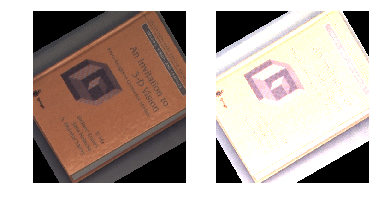

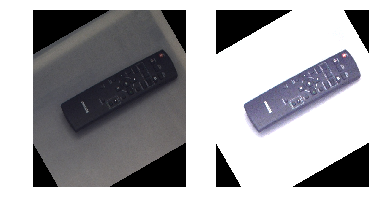

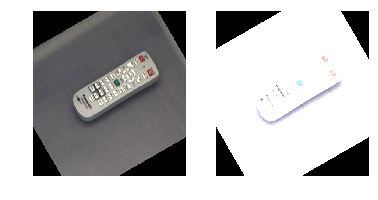

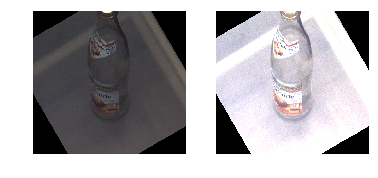

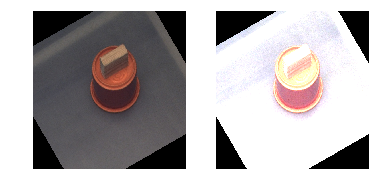

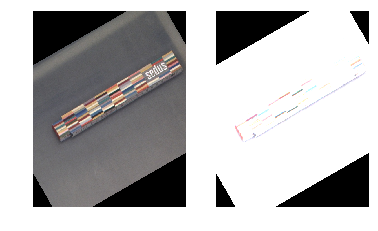

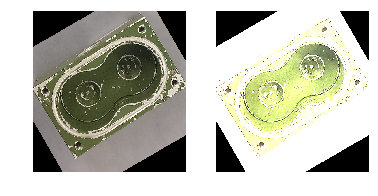

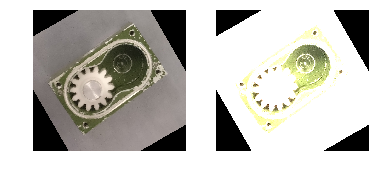

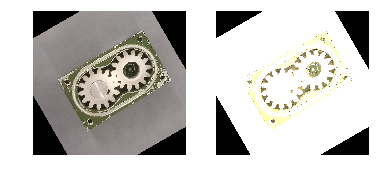

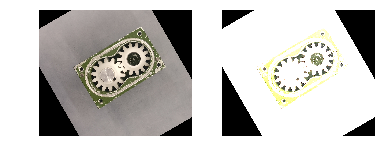

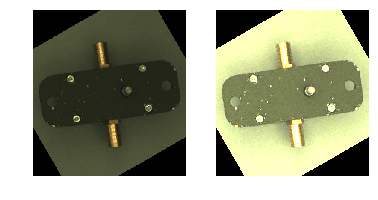

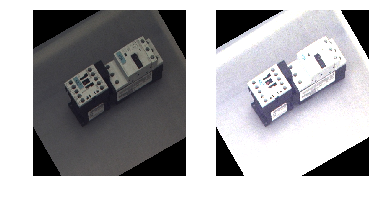

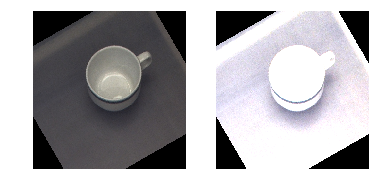

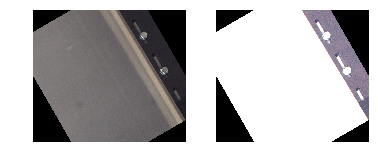

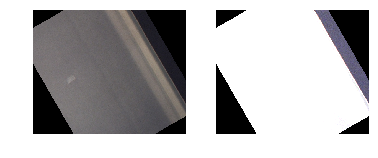

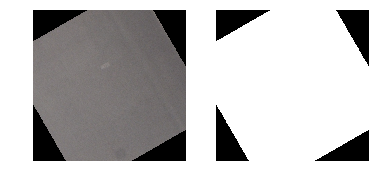

In [31]:
for img in list_imagesClean:
    pil_im = Image.open(img)
    for num in  range(0, 330, 30):
        pil_rot = pil_im.rotate(num)
        pil_rot.save('imagesTrain/'+img.split('/')[13][:-4]+str(num)+'.jpg')
        for num2 in range(4,44,10):
            img_bri=ImageEnhance.Brightness(pil_rot)
            img_new = img_bri.enhance(num2/10)
            img_new.save('imagesTrain/'+img.split('/')[13][:-4]+str(num)+str(num2)+'.jpg')

    plt.figure()
    plt.subplot(121)
    plt.imshow(pil_rot)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(img_new)
    plt.axis('off')
    plt.show()       



# Training

In [14]:
import os
import re
import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

C:\Users\hes39444\Desktop\Incep0\Inception\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Image-List

In [33]:
model_dir = '/models/tutorials/image/imagenet/'
img_dir = '/imagesTrain/'
list_images = [img_dir+f for f in os.listdir(img_dir) if re.search('jpg|JPG', f)]
print('NumberImages: '+str(len(list_images)))


NumberImages: 880


## Prepare InceptionV3

In [34]:
def create_graph():
    with gfile.FastGFile(os.path.join(model_dir,'classify_image_graph_def.pb'),'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _=tf.import_graph_def(graph_def,name='')

In [35]:
def extract_features(list_images):
    nb_features = 2048
    features = np.empty((len(list_images),nb_features))
    labels=[]
    create_graph()
    with tf.Session() as sess:
        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
        for ind, image in enumerate(list_images):
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist %s',image)
            image_data = gfile.FastGFile(image,'rb').read()
            predictions = sess.run(next_to_last_tensor,feed_dict={'DecodeJpeg/contents:0':image_data})
            features[ind,:] = np.squeeze(predictions)
            labels.append(re.split('_\d+',image.split('/')[13])[0])
    return features, labels           

In [78]:
#sess= tf.Session()
#sess.graph.get_operations()


## Extract Features

In [36]:
%%time
features,labels= extract_features(list_images)

Wall time: 4min


In [12]:
# with open('features.pickle', 'w+b') as fp:
#             p = pickle.dump(features, fp)
# with open('labels.pickle', 'w+b') as fp:
#             p = pickle.dump(labels, fp)

880 0.322933639336 0.29947750838


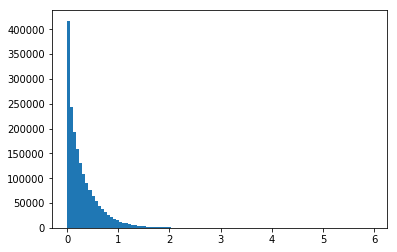

In [37]:
features = pickle.load(open('features.pickle', 'rb'))
labels = pickle.load(open('labels.pickle', 'rb'))
print(len(labels),features.std(),features.mean())
a = plt.hist(features.flatten(),bins=100)
plt.show()


In [15]:
features[0].shape

(2048,)

## Train Linear SVM

### Test-Train Split

In [13]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, labels, test_size=0.01, random_state=42)

### Train

In [14]:
%%time
clf = LinearSVC(C=1.0, loss='squared_hinge', penalty='l2',multi_class='ovr')
clf.fit(X_train, y_train)

Wall time: 2.34 s


### Test

In [15]:
%%time
y_pred = clf.predict(X_test)

Wall time: 1e+03 µs


In [16]:
def plot_confusion_matrix(y_true,y_pred):
    cm_array = confusion_matrix(y_true,y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array[:-1,:-1], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels))
    ytick_marks = np.arange(len(pred_labels))
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size

Accuracy: 100.0%


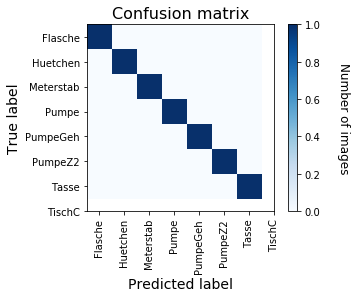

In [17]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(y_test,y_pred)*100))
plot_confusion_matrix(y_test,y_pred)

## Test with new Images

In [22]:
img_dir = '/imgTest/'
list_images = [img_dir+f for f in os.listdir(img_dir) if re.search('jpg|JPG', f)]
#for img in list_images:
    #imgo = Image.open(img)
    #imgo = imgo.resize((299,299))
    #plt.figure()
    #plt.imshow(imgo)
    #plt.axis('off')
    #plt.show()

In [23]:
%%time
featuresTest,labelsTest= extract_features(list_images)

Wall time: 16.9 s


In [25]:
%%time
y = clf.predict(featuresTest)
fu  = clf.decision_function(featuresTest)
classes = clf.classes_
print(clf.classes_[0])
print(y)

Buch
['Buch' 'Buch' 'Buch' 'Buch' 'Flasche' 'Buch' 'FernbedienungA'
 'FernbedienungB' 'Flasche' 'Huetchen' 'Huetchen' 'Huetchen' 'Pumpe'
 'Flasche' 'Pumpe' 'Pumpe' 'PumpeZ1' 'PumpeZ1' 'PumpeZ2' 'PumpeZ2' 'Pumpe'
 'TischB' 'TischC' 'Tisch']
Wall time: 1 ms


Label: BuchBSeg   Prediction: Buch  Top3: Buch(0.325),  Meterstab(-0.78),  Huetchen(-0.83)


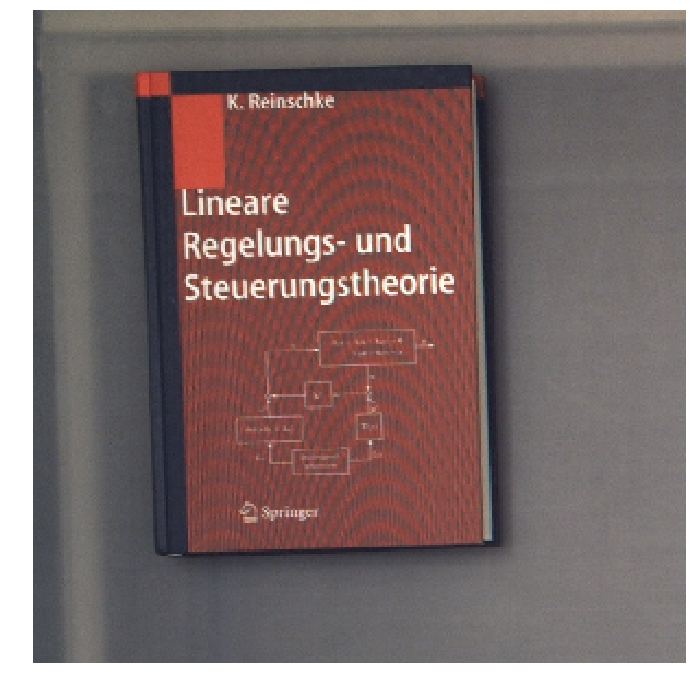

Label: BuchCSeg   Prediction: Buch  Top3: Buch(0.814),  Meterstab(-0.64),  PumpeZ2(-0.77)


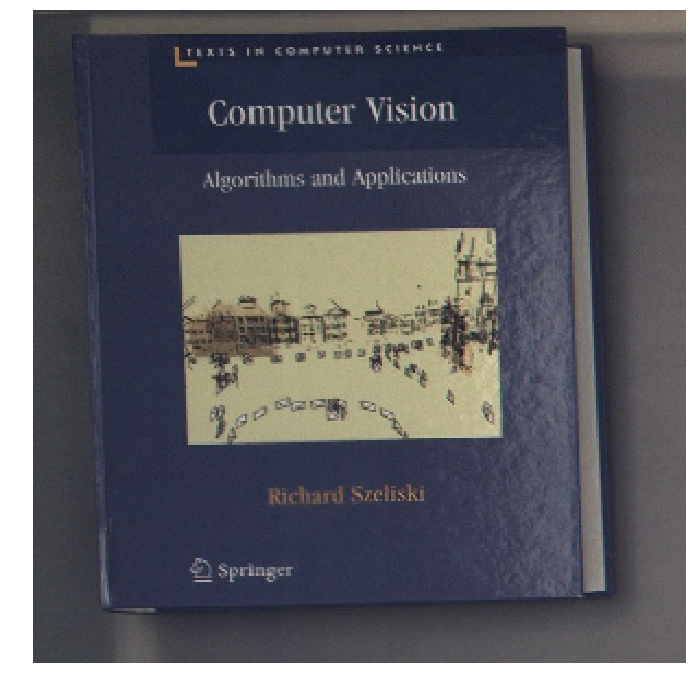

Label: BuchhandA   Prediction: Buch  Top3: Buch(-0.18),  Pumpe(-0.70),  Meterstab(-0.77)


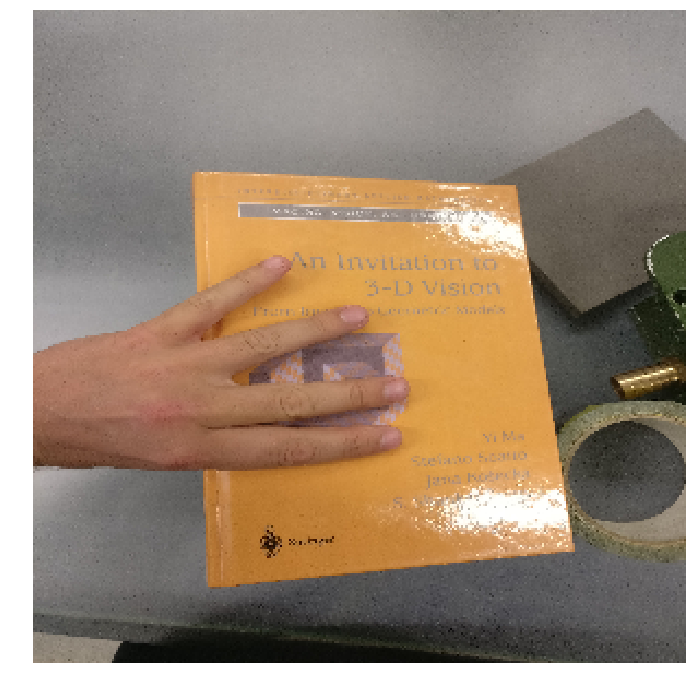

Label: BuchhandB   Prediction: Buch  Top3: Buch(-0.43),  Meterstab(-0.89),  Huetchen(-1.06)


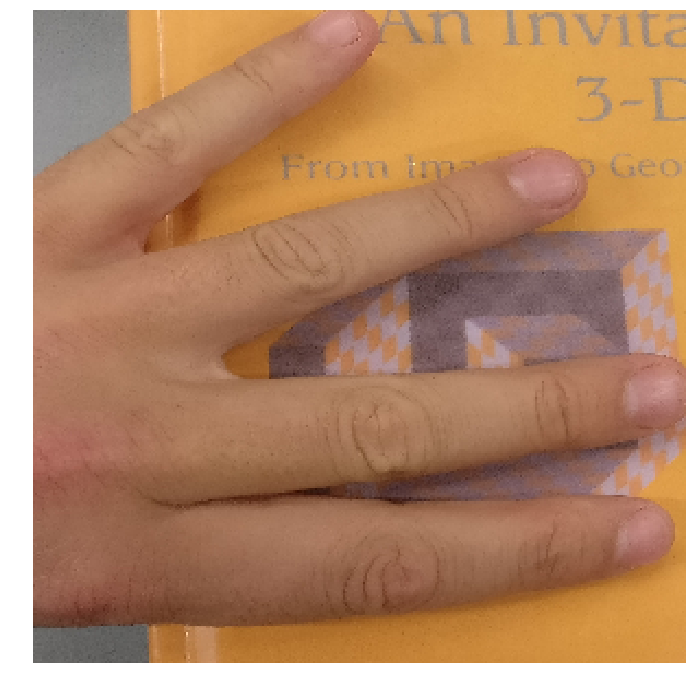

Label: BuchhDEck   Prediction: Flasche  Top3: Flasche(-0.90),  Buch(-0.91),  Tasse(-0.93)


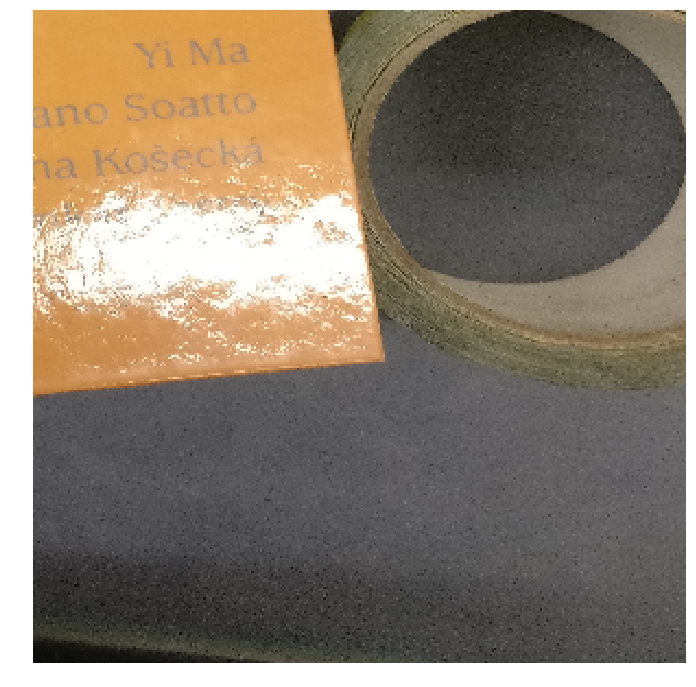

Label: buch   Prediction: Buch  Top3: Buch(-0.46),  Meterstab(-1.04),  Flasche(-1.15)


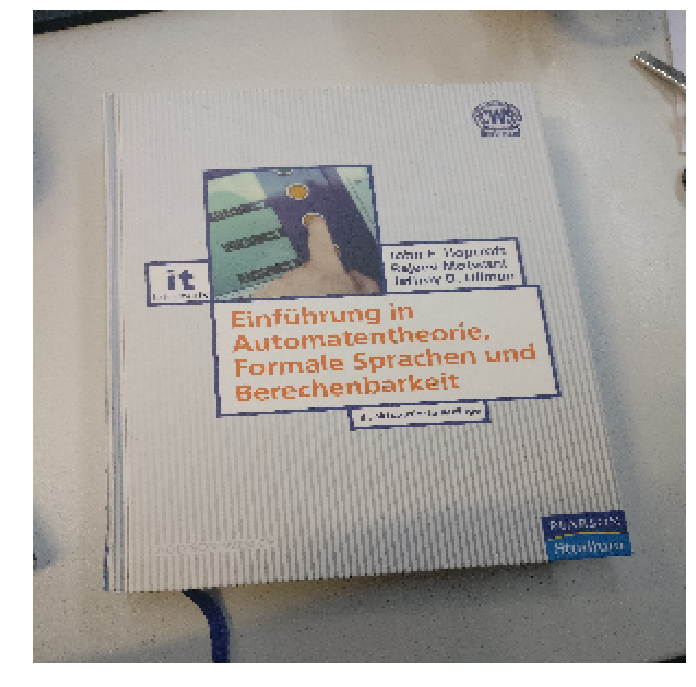

Label: FernbedienungA   Prediction: FernbedienungA  Top3: FernbedienungA(-0.67),  Tisch(-1.20),  Huetchen(-1.24)


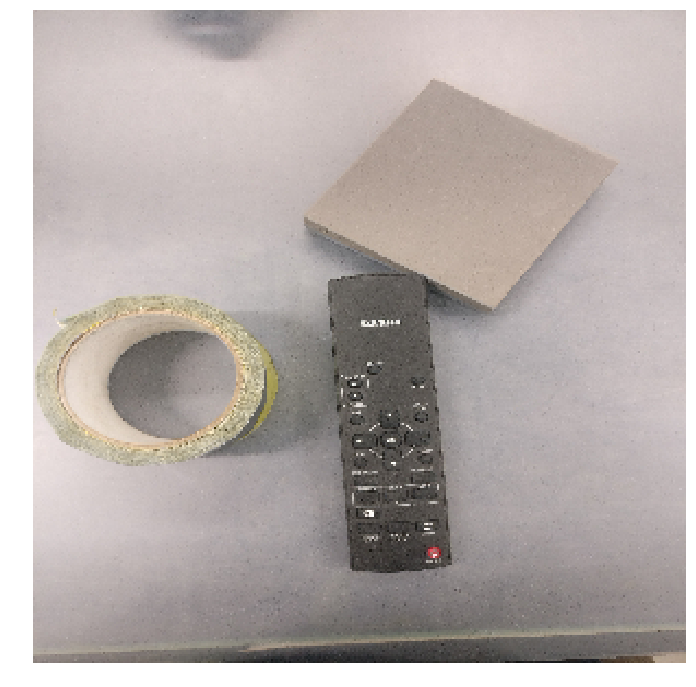

Label: FernbedienungB   Prediction: FernbedienungB  Top3: FernbedienungB(-0.47),  Pumpe(-1.02),  PumpeZ2(-1.04)


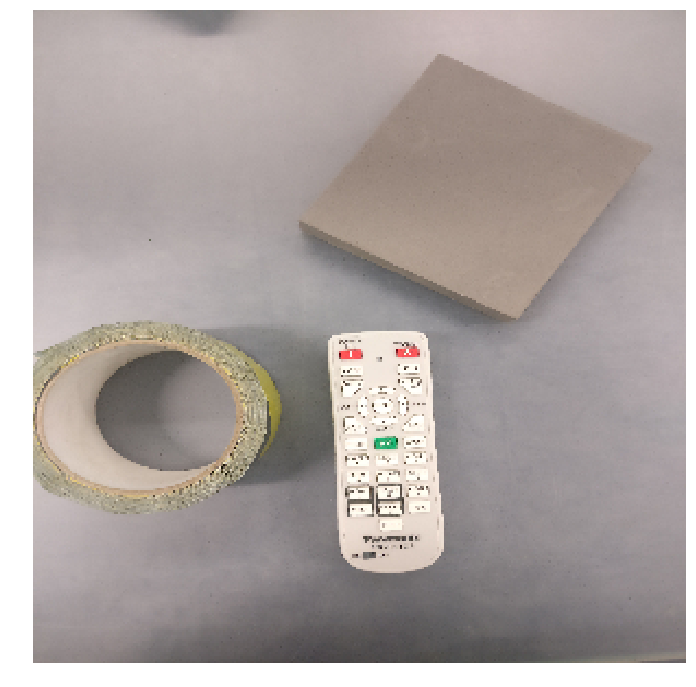

Label: Flasche   Prediction: Flasche  Top3: Flasche(-0.00),  Meterstab(-1.01),  Buch(-1.09)


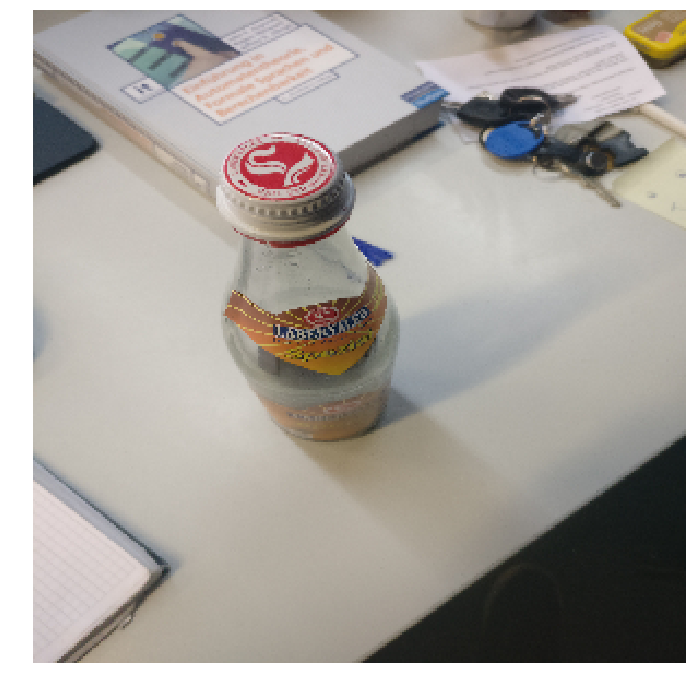

Label: huetchenB   Prediction: Huetchen  Top3: Huetchen(-0.52),  Meterstab(-0.52),  PumpeZ2(-1.09)


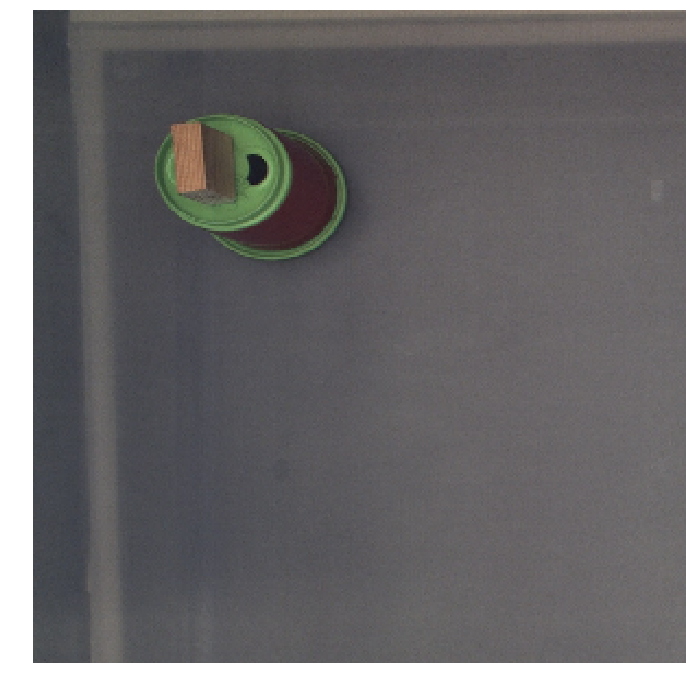

Label: huetchenB   Prediction: Huetchen  Top3: Huetchen(-0.47),  Meterstab(-0.84),  PumpeZ2(-0.97)


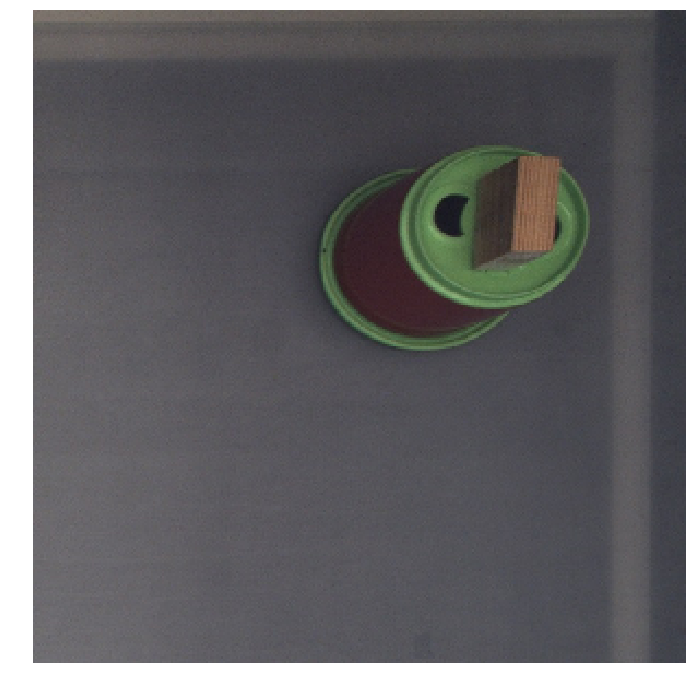

Label: huetchenB   Prediction: Huetchen  Top3: Huetchen(-0.37),  PumpeZ2(-0.79),  PumpeZ1(-0.87)


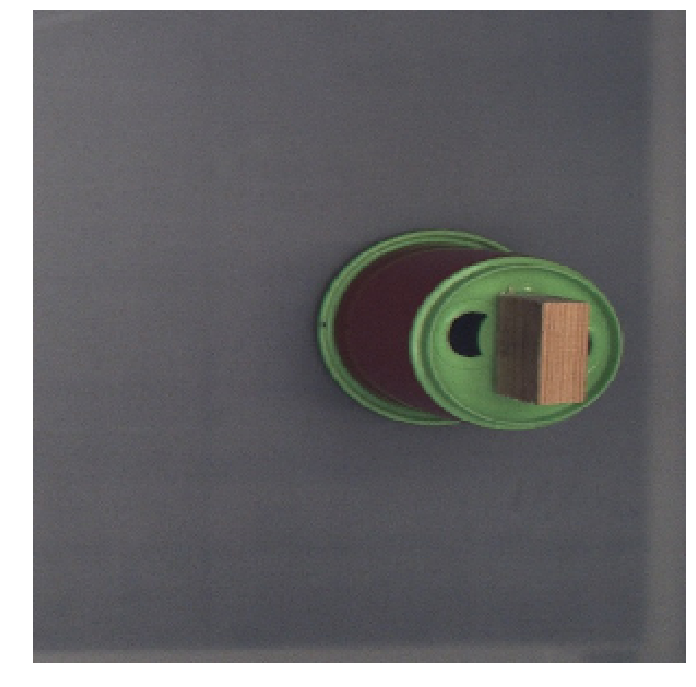

Label: PumpeC   Prediction: Pumpe  Top3: Pumpe(-0.65),  Tasse(-1.00),  Meterstab(-1.18)


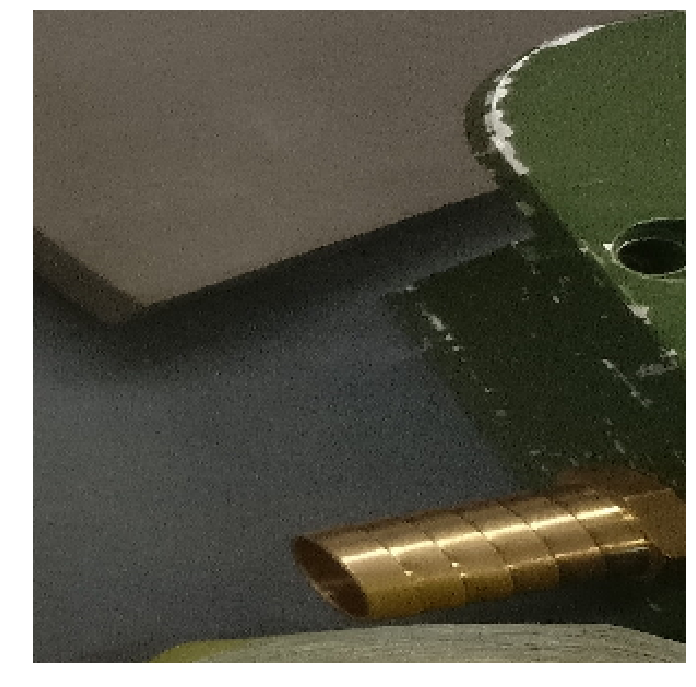

Label: PumpeHandA   Prediction: Flasche  Top3: Flasche(-0.66),  Pumpe(-0.73),  Huetchen(-0.98)


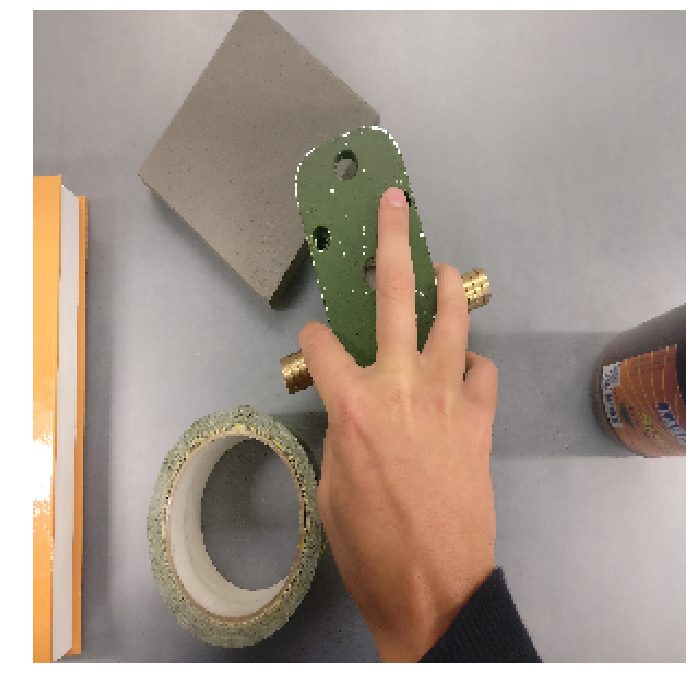

Label: PumpeHandB   Prediction: Pumpe  Top3: Pumpe(-0.49),  Huetchen(-0.90),  Flasche(-0.99)


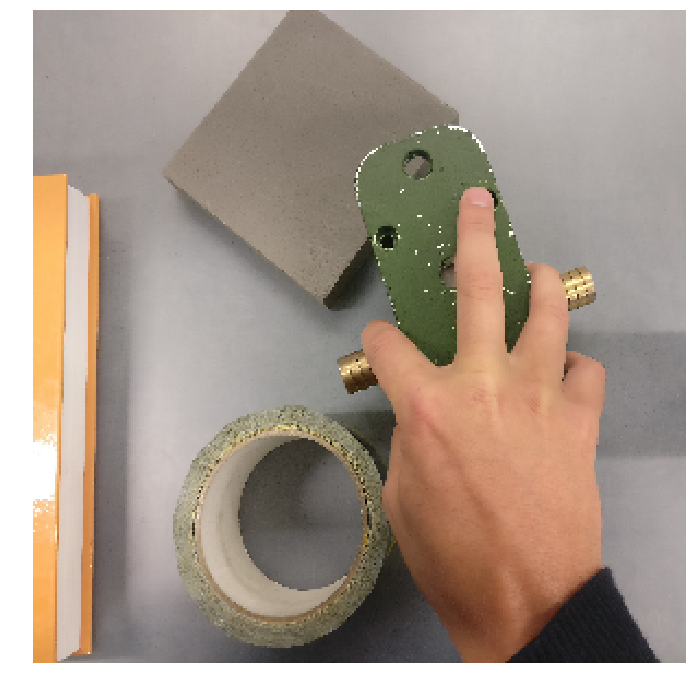

Label: PumpeHandC   Prediction: Pumpe  Top3: Pumpe(-0.69),  Flasche(-0.80),  Huetchen(-1.04)


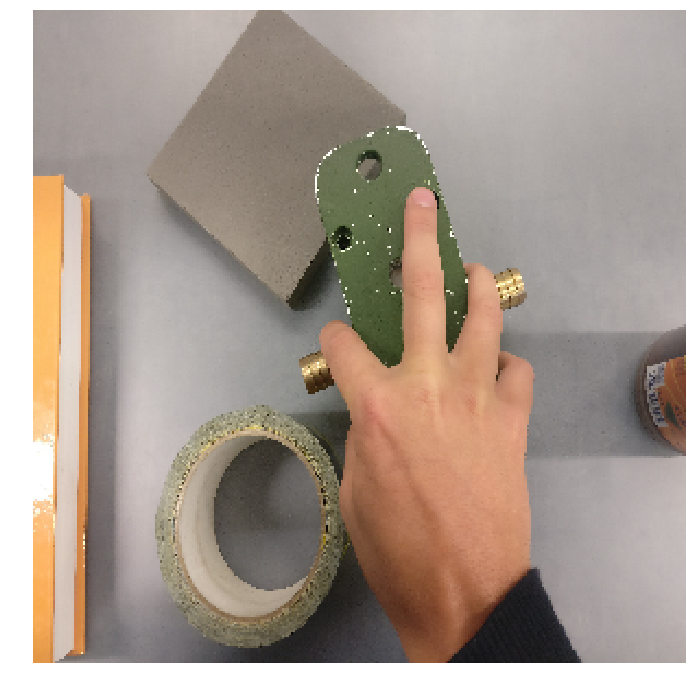

Label: PumpeZ1Scharf   Prediction: PumpeZ1  Top3: PumpeZ1(0.396),  PumpeZ2(-0.29),  Schutzschalter(-0.87)


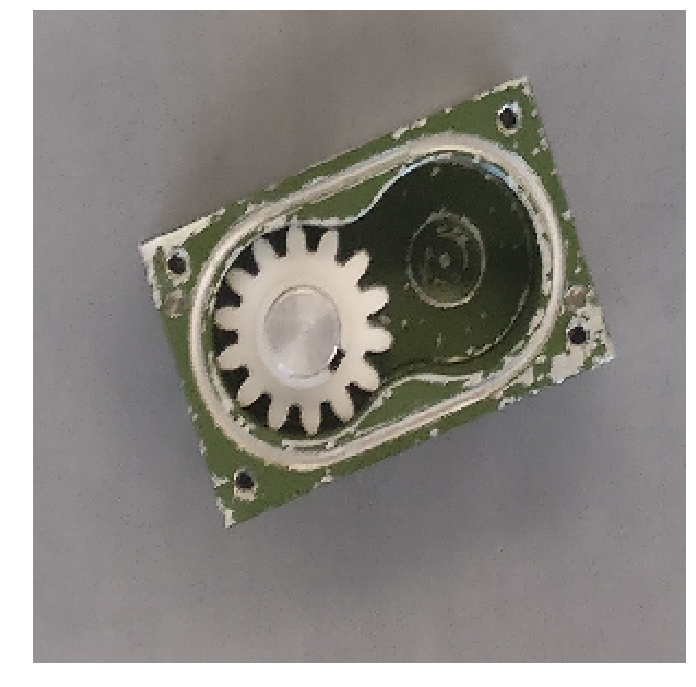

Label: PumpeZ1unscharf   Prediction: PumpeZ1  Top3: PumpeZ1(1.481),  Buch(-1.13),  FernbedienungA(-1.13)


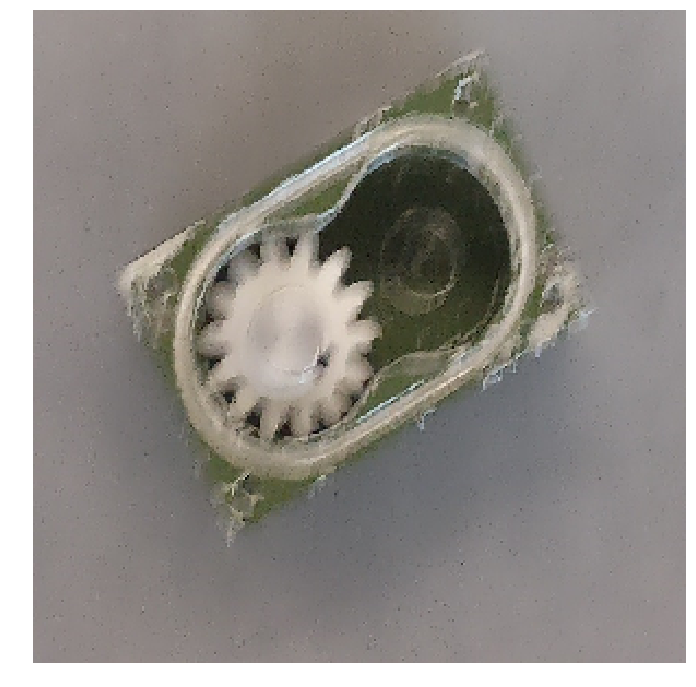

Label: PumpeZ2D   Prediction: PumpeZ2  Top3: PumpeZ2(0.278),  PumpeZ1(-0.22),  Pumpe(-0.70)


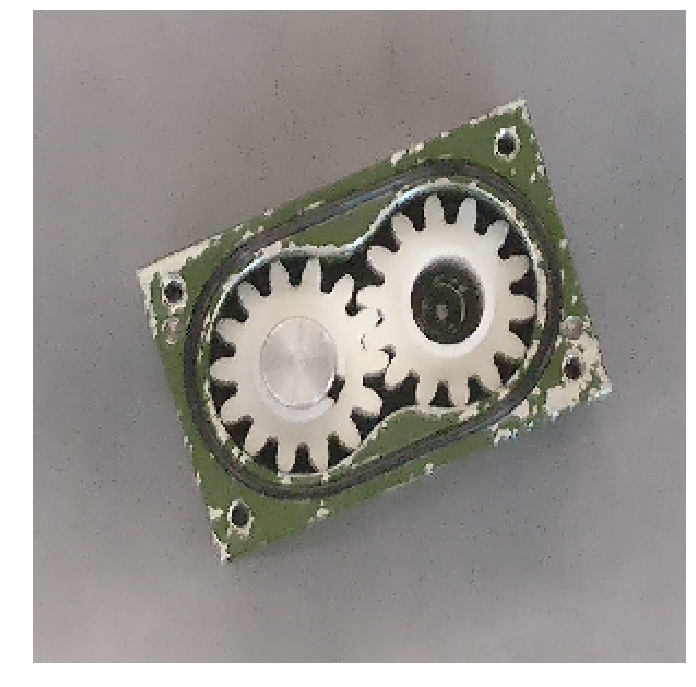

Label: PumpeZ2   Prediction: PumpeZ2  Top3: PumpeZ2(0.501),  PumpeZ1(-0.43),  Pumpe(-0.80)


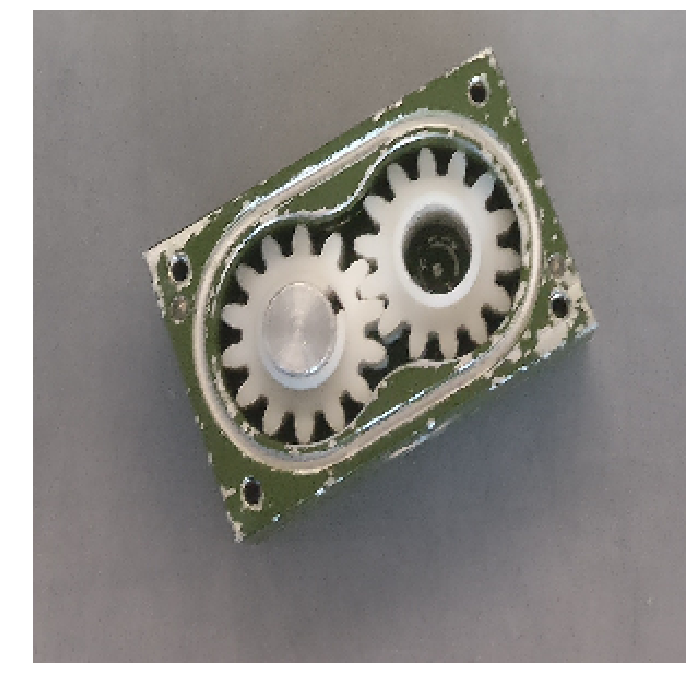

Label: pumpe   Prediction: Pumpe  Top3: Pumpe(-0.19),  PumpeZ2(-0.58),  Flasche(-0.69)


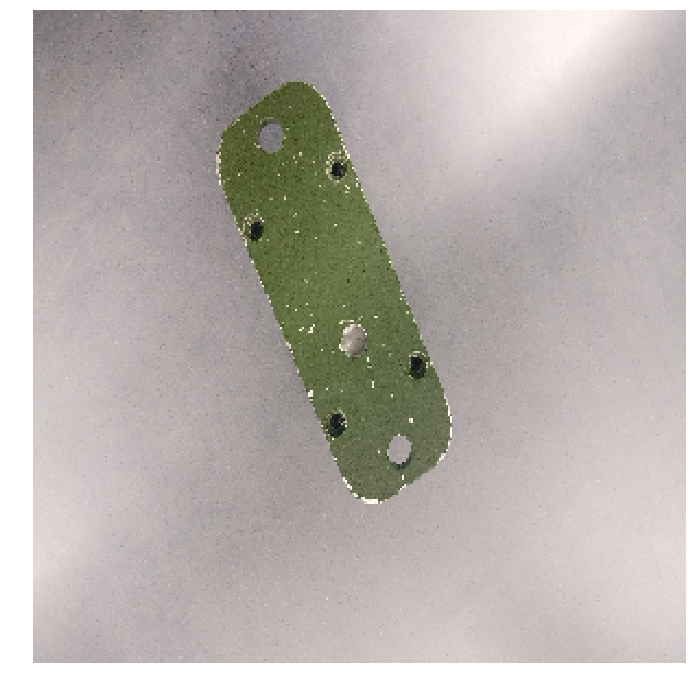

Label: TischB   Prediction: TischB  Top3: TischB(0.805),  TischC(-1.00),  Flasche(-1.06)


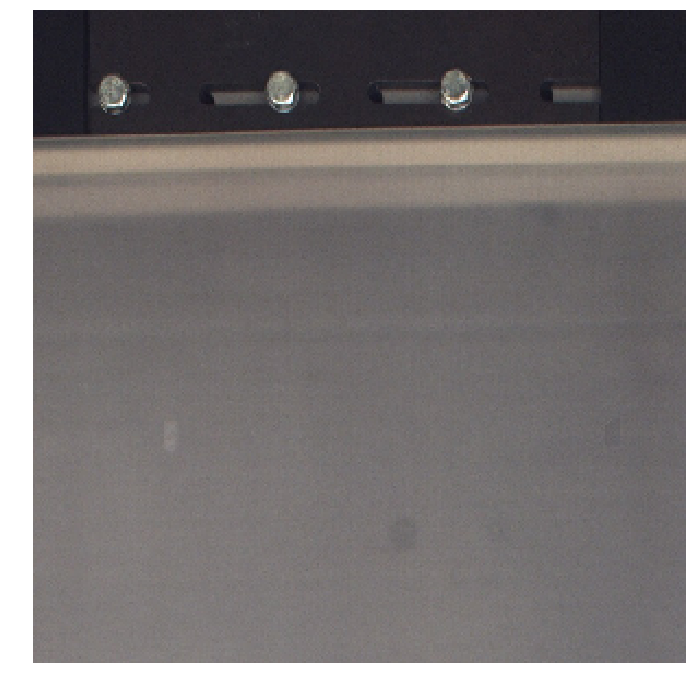

Label: TischC   Prediction: TischC  Top3: TischC(1.560),  Buch(-1.01),  Huetchen(-1.01)


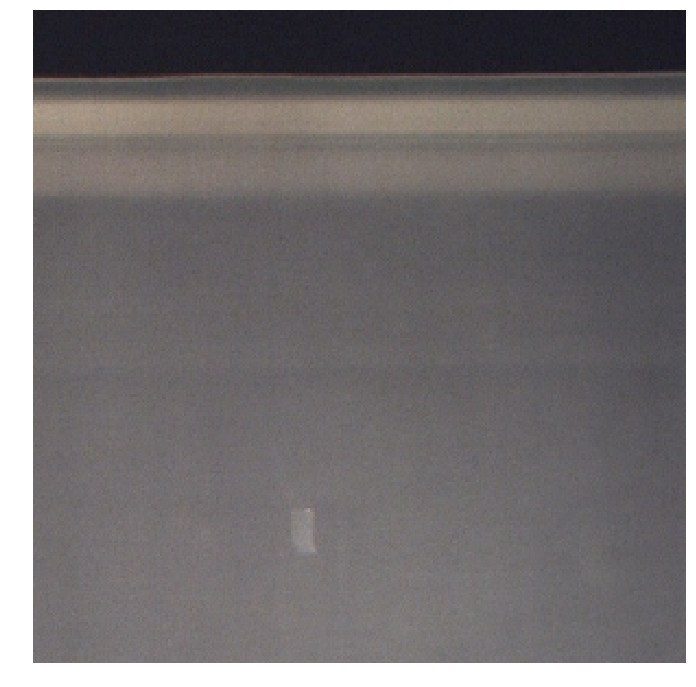

Label: Tisch   Prediction: Tisch  Top3: Tisch(0.553),  TischC(-0.81),  Huetchen(-0.94)


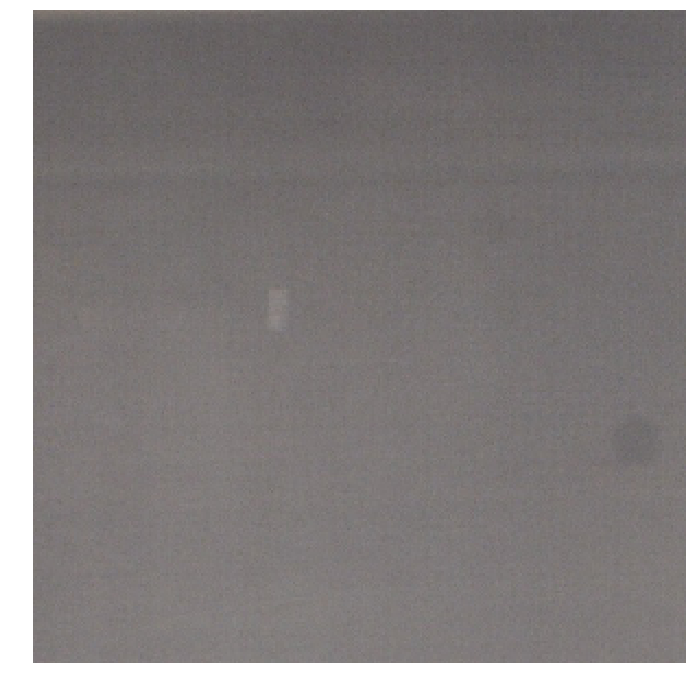

In [39]:
import time
for num,img in enumerate(list_images):
    idx = sorted(range(len(fu[num])), key=lambda k: fu[num][k])
    print('Label: ' +labelsTest[num]+ '   Prediction: ' +y[num]+ '  Top3: ' + classes[idx[-1]] + '(' + str(fu[num][idx[-1]])[:5]+ '),  '+ classes[idx[-2]] + '(' + str(fu[num][idx[-2]])[:5]+ '),  '+ classes[idx[-3]] + '(' + str(fu[num][idx[-3]])[:5]+ ')')
    imgo = Image.open(img)
    imgo = imgo.resize((299,299))
    plt.imshow(imgo)
    plt.axis('off')
    time.sleep(0.1)
    plt.show()

In [84]:
model_dir = '/models/tutorials/image/imagenet/'
img_dir = '/imagesTrain/'
list_images = [img_dir+f for f in os.listdir(img_dir) if re.search('jpg|JPG', f)]
print('NumberImages: '+str(len(list_images)))    
create_graph()
with tf.Session() as sess:
            img =  list_images[0]
            image_data = gfile.FastGFile(img,'rb').read()
            next_to_last_tensor = sess.graph.get_tensor_by_name('DecodeJpeg:0')
            predictions = sess.run(next_to_last_tensor,feed_dict={ 'DecodeJpeg/contents:0':image_data})
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "LogDir"
logdir ="{}/run-{}/".format(root_logdir,now)
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())
file_writer.close()


NumberImages: 880


In [38]:
#tf.get_default_graph().get_operations()

## Check for Linear Correlation between Rotated Features

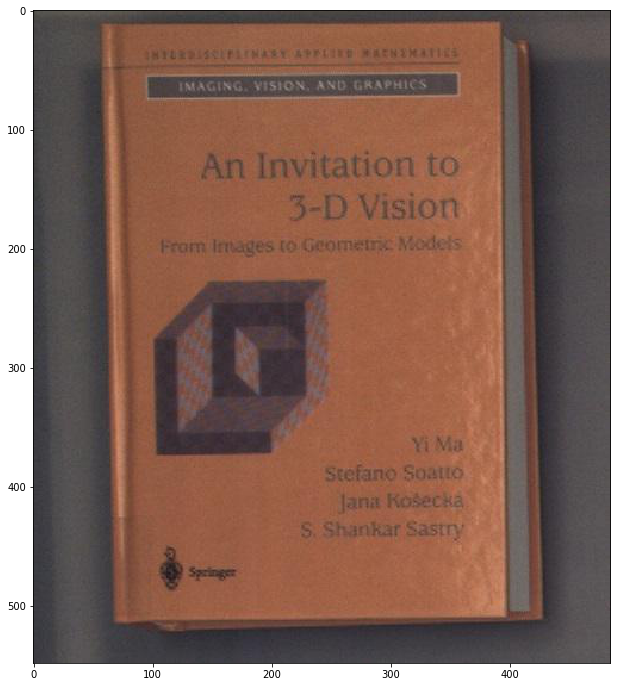

In [86]:
plt.imshow(predictions)

In [109]:
import pandas as pd
pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

height has been deprecated.



In [110]:
Buch =features[ [num for num,item in enumerate(labels) if item == 'Buch']]

In [112]:
corr = pd.DataFrame(np.corrcoef(Buch))
corr[:]

0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54
0   1.000000  0.976670  0.847121  0.755547  0.806334  0.495375  0.497923  0.467102  0.310888  0.474751  0.598068  0.612056  0.512102  0.412110  0.566704  0.802131  0.805123  0.710421  0.598922  0.734043  0.574055  0.564949  0.468663  0.393630  0.550521  0.509055  0.496301  0.457841  0.354775  0.526426  0.533659  0.518479  0.499706  0.333455  0.506732  0.609135  0.510456  0.503454  0.522989  0.319653  0.471425  0.634189  0.548708  0.408533  0.581568  0.582287  0.561216  0.490183  0.352308  0.562966  0.448575  0.460804  0.420689  0.275013  0.506646
1   0.976670  1.000000  0.843973  0.743808  0.764547  0.511870  0.516538  0.482687  0.334327  0.484426  0.605876  0.622259  0.530058  0.439202  0.562305  0.806523  0.815268  0.710763  0.585745  0.720146  0.590975  0.585661  0.480750  0.419425  0.567288  0.527213  0.516021  0.477999  0.377382  0.537897  0.532548  0.517229  0.496830  0.314240  0.495144  0.627862  0.524722  0.519339  0.534031  0.340829  0.486431  0.654541  0.566108  0.425652  0.591088  0.597803  0.577795  0.510501  0.375122  0.578156  0.455306  0.470828  0.424368  0.272101  0.503524
2   0.847121  0.843973  1.000000  0.816409  0.696885  0.452433  0.455782  0.488102  0.353478  0.443356  0.539263  0.547658  0.569391  0.464898  0.510511  0.669340  0.705317  0.821133  0.685281  0.630404  0.555362  0.549860  0.510188  0.453224  0.543846  0.454915  0.456631  0.501041  0.398977  0.471754  0.425772  0.428932  0.504297  0.306564  0.396377  0.565041  0.489036  0.481038  0.548991  0.387536  0.456206  0.587782  0.602939  0.476929  0.535237  0.480427  0.473962  0.506111  0.386148  0.494145  0.382027  0.385616  0.443047  0.290040  0.390288
3   0.755547  0.743808  0.816409  1.000000  0.670708  0.446487  0.460956  0.499625  0.440662  0.443077  0.497723  0.512776  0.544190  0.532609  0.506663  0.612128  0.628041  0.725266  0.776814  0.600743  0.531913  0.528968  0.510670  0.515135  0.537683  0.425228  0.431080  0.472194  0.454006  0.472781  0.411500  0.407768  0.497417  0.390198  0.419271  0.530230  0.462990  0.444979  0.533768  0.435804  0.455135  0.560300  0.582220  0.560559  0.532290  0.469061  0.461448  0.506614  0.455447  0.502245  0.314198  0.324132  0.395773  0.346709  0.398886
4   0.806334  0.764547  0.696885  0.670708  1.000000  0.448613  0.446648  0.424727  0.323494  0.482451  0.554924  0.536121  0.440905  0.384580  0.557088  0.704956  0.670143  0.631557  0.616079  0.782645  0.526436  0.508747  0.441084  0.386869  0.549184  0.443117  0.428937  0.418353  0.365434  0.529509  0.493507  0.467508  0.487258  0.407943  0.551642  0.573798  0.456858  0.452787  0.464025  0.332336  0.462921  0.572341  0.494168  0.409348  0.587456  0.523383  0.494933  0.459943  0.337099  0.570360  0.429922  0.427784  0.401043  0.307383  0.543831
5   0.495375  0.511870  0.452433  0.446487  0.448613  1.000000  0.985753  0.890664  0.769125  0.919147  0.790587  0.796141  0.699694  0.731166  0.721966  0.549030  0.556791  0.509259  0.446079  0.516891  0.804096  0.815851  0.716859  0.714349  0.779234  0.877892  0.884447  0.824631  0.680082  0.823391  0.697028  0.679992  0.699865  0.543633  0.673972  0.809650  0.877046  0.875227  0.839558  0.697545  0.823412  0.802452  0.703213  0.708678  0.775830  0.877141  0.883058  0.861635  0.783438  0.849022  0.701531  0.711677  0.717093  0.583469  0.695073
6   0.497923  0.516538  0.455782  0.460956  0.446648  0.985753  1.000000  0.894795  0.776302  0.899945  0.794907  0.804627  0.700663  0.730

In [119]:
np.where(corr==1)

(array([ 0,  1,  3,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 17, 19, 20, 21,
        22, 23, 24, 26, 28, 29, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 45, 46, 47, 48, 50, 51, 53, 54], dtype=int64),
 array([ 0,  1,  3,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 17, 19, 20, 21,
        22, 23, 24, 26, 28, 29, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 45, 46, 47, 48, 50, 51, 53, 54], dtype=int64))

In [122]:
print(list_images[11],list_images[14],list_images[10])

P:/MB/Labore/Robotics/007_TeRob/99_Homes/hes39444/05_Documentation/01_Presentation/Thesis/VisionJourfixe/Inception-SVM/imagesTrain/Buch_115014.jpg P:/MB/Labore/Robotics/007_TeRob/99_Homes/hes39444/05_Documentation/01_Presentation/Thesis/VisionJourfixe/Inception-SVM/imagesTrain/Buch_11504.jpg P:/MB/Labore/Robotics/007_TeRob/99_Homes/hes39444/05_Documentation/01_Presentation/Thesis/VisionJourfixe/Inception-SVM/imagesTrain/Buch_1150.jpg
